In [1]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("minute_data/BTC-USD_1M_SIGNALS.csv")

In [3]:
data

,Unix,Date,Symbol,Open,High,Low,Close,Volume USD,Variation,RSI,MACD,MACD_H,-DM,+DM,ADX14
0,1483228860,2017-01-01 00:01:00,BTC/USD,966.34,966.34,966.34,966.34,-0.312459,-0.006352,-0.241664,0.003268,0.001095,-0.296745,-0.163178,-0.614737
1,1483228920,2017-01-01 00:02:00,BTC/USD,966.16,966.37,966.16,966.37,-0.310186,-0.000855,0.676875,0.003534,0.002246,-0.285351,-0.163178,-0.664197
2,1483228980,2017-01-01 00:03:00,BTC/USD,966.37,966.37,966.37,966.37,-0.348678,-0.000855,0.676875,0.003738,0.003484,-0.296745,-0.163178,-0.643473
3,1483229040,2017-01-01 00:04:00,BTC/USD,966.37,966.37,966.37,966.37,-0.348678,-0.011849,0.682925,0.003932,0.004996,-0.293490,-0.163178,-0.645875
4,1483229100,2017-01-01 00:05:00,BTC/USD,966.43,966.43,966.43,966.43,-0.348169,-0.028336,0.744369,0.004110,0.006831,-0.288606,-0.163178,-0.648277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2675129,1646105880,2022-03-01 03:38:00,BTC/USD,43077.82,43077.82,43049.46,43049.46,-0.343969,0.205143,2.657823,202.140130,315.950658,-0.296745,1.189788,0.568915
2675130,1646105940,2022-03-01 03:39:00,BTC/USD,43035.16,43035.16,42999.44,42999.44,-0.174815,-0.069151,2.657242,182.098937,328.738652,0.603408,-0.163178,0.177030
2675131,1646106000,2022-03-01 03:40:00,BTC/USD,43022.24,43022.24,43016.03,43016.03,-0.346723,-0.126531,2.657241,153.986631,318.063305,-0.177376,-0.163178,-0.187756
2675132,1646106060,2022-03-01 03:41:00,BTC/USD,43018.23,43046.59,43018.23,43046.58,-0.318365,-0.000855,2.657987,115.826724,271.530088,1.241492,-0.163178,-0.535597


In [4]:
data["Variation STD"] = data["Variation"].rolling(14).std()
data = data[[i%100 == 0 for i in range(len(data))]]
data = data.dropna()

In [5]:
data

,Unix,Date,Symbol,Open,High,Low,Close,Volume USD,Variation,RSI,MACD,MACD_H,-DM,+DM,ADX14,Variation STD
100,1483234860,2017-01-01 01:41:00,BTC/USD,964.15,964.15,964.15,964.15,-0.348678,0.197730,-0.022690,-0.005735,0.002012,-0.296745,-0.128926,2.561852e-01,6.948334e-02
200,1483240860,2017-01-01 03:21:00,BTC/USD,963.99,963.99,963.99,963.99,-0.348678,-0.000855,-0.354728,0.001134,-0.002778,-0.296745,-0.163178,-5.587067e-01,1.000706e-02
300,1483246860,2017-01-01 05:01:00,BTC/USD,963.02,963.02,963.02,963.02,-0.348529,-0.000855,2.660454,-0.001572,0.001322,-0.296745,-0.163178,3.398648e-14,5.247266e-02
400,1483252860,2017-01-01 06:41:00,BTC/USD,964.75,964.99,964.75,964.99,-0.317589,-0.000855,2.660454,-0.000383,0.000086,-0.283723,-0.163178,3.398648e-14,4.934952e-02
500,1483258860,2017-01-01 08:21:00,BTC/USD,964.96,964.96,964.96,964.96,-0.348678,-0.000855,-0.697359,-0.001046,-0.000043,-0.296745,-0.163178,-2.780615e-01,4.929339e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2674700,1646080140,2022-02-28 20:29:00,BTC/USD,41700.00,41701.63,41643.63,41680.93,1.757530,0.243179,0.017561,-0.935886,0.594786,-0.296745,-0.163178,3.450658e-01,2.671564e-01
2674800,1646086140,2022-02-28 22:09:00,BTC/USD,41841.35,41897.52,41835.71,41897.52,-0.264580,0.317346,-0.353801,-5.995334,4.843307,-0.296745,2.220212,-3.015561e-01,2.142543e-01
2674900,1646092140,2022-02-28 23:49:00,BTC/USD,43207.87,43247.11,43207.87,43247.11,-0.175461,-0.068965,-0.611275,-0.911115,0.063940,2.591451,-0.163178,-7.865831e-02,1.827362e-01
2675000,1646098140,2022-03-01 01:29:00,BTC/USD,43298.94,43302.75,43275.95,43289.21,-0.299957,-0.181277,-1.089279,0.021000,-1.141319,-0.296745,-0.163178,7.800619e-01,1.261677e-01


In [6]:
data_19_20 = data.loc[(data["Unix"] >= 1546300800) & (
        data["Unix"] < 1609459200)].reset_index(drop=True)

data_2021 = data.loc[data["Unix"] >= 1609459200].reset_index(drop=True)

gm = GaussianMixture(2)
#labels = gm.fit_predict(data_19_20.drop(["Unix", "Open", "High", "Low", "Close", "Date", "Symbol"], axis=1))
labels = gm.fit_predict(np.array(data_19_20["Variation STD"]).reshape(-1,1))

In [7]:
data_19_20

,Unix,Date,Symbol,Open,High,Low,Close,Volume USD,Variation,RSI,MACD,MACD_H,-DM,+DM,ADX14,Variation STD
0,1546302180,2019-01-01 00:23:00,BTC/USD,3688.35,3688.35,3688.35,3688.35,-0.346812,-0.000855,-1.026015,-0.056799,-0.049652,-0.296745,-0.163178,1.962837,0.071505
1,1546308180,2019-01-01 02:03:00,BTC/USD,3681.18,3681.18,3681.18,3681.18,-0.334579,-0.000855,0.378384,0.013585,-0.005640,-0.296745,-0.163178,-0.154577,0.081735
2,1546314180,2019-01-01 03:43:00,BTC/USD,3680.10,3685.50,3680.10,3680.63,-0.308528,0.047271,-0.014501,-0.030088,0.005923,-0.296745,-0.076913,2.098840,0.052862
3,1546320180,2019-01-01 05:23:00,BTC/USD,3692.65,3692.85,3692.65,3692.85,-0.346629,0.231544,0.696316,0.009339,0.052673,-0.296745,-0.160324,2.408547,0.088413
4,1546326180,2019-01-01 07:03:00,BTC/USD,3691.54,3691.56,3691.54,3691.56,-0.344751,-0.112555,-1.267293,-0.060398,-0.062496,-0.295660,-0.163178,-0.681862,0.076797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10128,1609432080,2020-12-31 16:28:00,BTC/USD,28734.68,28748.41,28701.15,28701.15,1.396310,0.178193,0.643261,1.097492,0.195875,-0.296745,1.329334,0.949579,0.167980
10129,1609438080,2020-12-31 18:08:00,BTC/USD,28614.67,28627.20,28589.94,28626.10,0.697694,-0.032213,-1.207123,-0.872709,-0.295962,-0.296745,-0.163178,2.306712,0.147218
10130,1609444080,2020-12-31 19:48:00,BTC/USD,28941.00,28983.16,28940.24,28969.32,0.952963,-0.145855,0.218437,0.036461,0.199492,0.620229,-0.163178,-0.412468,0.106500
10131,1609450080,2020-12-31 21:28:00,BTC/USD,29172.51,29172.51,29134.92,29148.68,-0.252816,0.019682,0.525663,0.653006,0.188968,0.264833,-0.163178,-0.370772,0.206877


<AxesSubplot:>

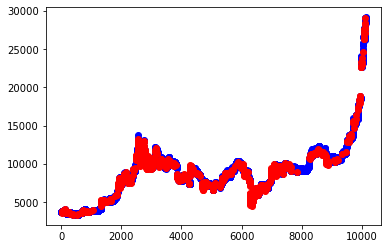

In [13]:
data_19_20["Label"] = labels
data_19_20["Close"][labels==0].plot(style='bo')#, alpha=0.2)
data_19_20["Close"][labels==1].plot(style='ro')#, alpha=0.2)

In [9]:
pd.Series(labels).value_counts()

0    9275
1     858
dtype: int64

<AxesSubplot:>

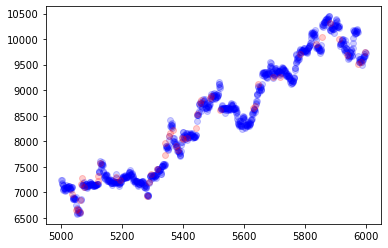

In [11]:
data_split = data_19_20[5000:6000]
data_split["Close"][data_split["Label"]==0].plot(style='bo', alpha=0.2)
data_split["Close"][data_split["Label"]==1].plot(style='ro', alpha=0.2)